In [1]:
#Paquetes utilizados
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
from statsmodels.tsa.stattools import adfuller
from pandas import Series
import matplotlib as mpl
warnings.simplefilter(action='ignore', category=FutureWarning)
from statsmodels.tsa import seasonal
import geopandas as gpd

# Análisis cualitativo y preparación de la base de datos

## 1. Análisis cualitativo

In [2]:
df = pd.read_csv("apl_raw (1).csv")

La base de datos de análisis corresponde a las cargas transportadas en los últimos 3 años de una empresa de camiones en Estado Unidos. Esta base tiene algunas variables como origen/destino de la carga, dinero recibido por el movimiento, despachador encargado, cliente que recibió la carga y distancia recorrida.

En este primer apartado el objetivo es conocer con qué variables se cuenta y entender un poco el actual estado de la compañía. Además de generar la variable de interés de cargas transportadas diarias sobre la cual se desarrollarán los modelos de pronóstico posteriormente. Esto dado que a priori se conoce que el nivel de servicio de la empresa no es adecuado y se sospecha que puede estar relacionado con la poca cobertura operacional para brindar un mejor servicio a la demanda solicitada.

### 1.1 Limpieza de la base de datos

A continuación se filtran las variables con que continuaremos el análisis, algunas variables como 'Hubs' de origen/destino, ciudad específica de origen/destino, fecha de facturación no serán consideradas en la base de datos.

Las variables de análisis incluyen el número de identificación de la carga, el despachador que se encargó de coordinar el envío, el dinero que se recibió por el movimiento, la distancia recorrida, el cliente que la recibió, el tipo de camión requerido para mover la carga y el estado y región de origen.

In [3]:
cols=['ID', 'DispatcherUser', 'RateTotal', 'Distance', 'Broker_Shipper', 'Posted',
 'Equip', 'RatePerMile', 'StateOrigin', 'RegionOrigin', 'Hora']

Además, observemos que existen 3 tipos de camiones con que esta empresa mueve cargas. No es adecuado hacer un análisis mezclando las 3 informaciones, por lo que hacemos un filtro para observa solo las cargas de camiones tipo 'reefer' que representan el mayor porcentaje de cargas.

In [4]:
df=df[cols]
piv=pd.pivot_table(df, values='ID', index='Equip', aggfunc='count')
piv

,ID
Equip,
FLATBED,2738
REEFER,31127
VAN,6708


In [5]:
df=df.loc[df['Equip']=='REEFER']

A partir de este filtro contamos ahora con 31,127 datos de cargas transportadas.

### 1.2 Análisis de clientes 'Brokers/Shippers'

La base de datos tiene 1,574 clientes únicos. Conozcamos a continuación cuáles son sus clientes más representativos, para tener resaltadas las empresas donde el nivel de servicio debe mejorar o mantenerse en alto nivel.

In [6]:
piv1=df.pivot_table(index='Broker_Shipper', values='ID', aggfunc='count', fill_value=0).reset_index()
piv1['Total']=piv1['ID'].sum()
piv1['Loads requested (%)']=piv1['ID']/piv1['Total']
piv1 = piv1.sort_values(by='Loads requested (%)', ascending=False)
piv1['acum']=piv1['Loads requested (%)'].cumsum()
piv1.head(10)

,Broker_Shipper,ID,Total,Loads requested (%),acum
1401,TOTAL QUALITY LOGISTICS,2512,31127,0.080702,0.080702
350,COYOTE LOGISTICS,1187,31127,0.038134,0.118836
725,JBS FOODS,1062,31127,0.034118,0.152954
113,ARRIVE LOGISTICS,1030,31127,0.033090,0.186044
1446,TRIPLE T TRANSPORT INC,822,31127,0.026408,0.212452
928,MOLO SOLUTIONS LLC,734,31127,0.023581,0.236033
65,ALLEN LUND CO,642,31127,0.020625,0.256658
728,JEAR LOGISTICS LLC,480,31127,0.015421,0.272079
448,EASE LOGISTICS,421,31127,0.013525,0.285604
110,ARMSTRONG TRANSPORT GROUP,405,31127,0.013011,0.298615


C:\Users\kgome\AppData\Local\Temp\ipykernel_11416\1323940040.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=10, ha='right', fontsize=10)


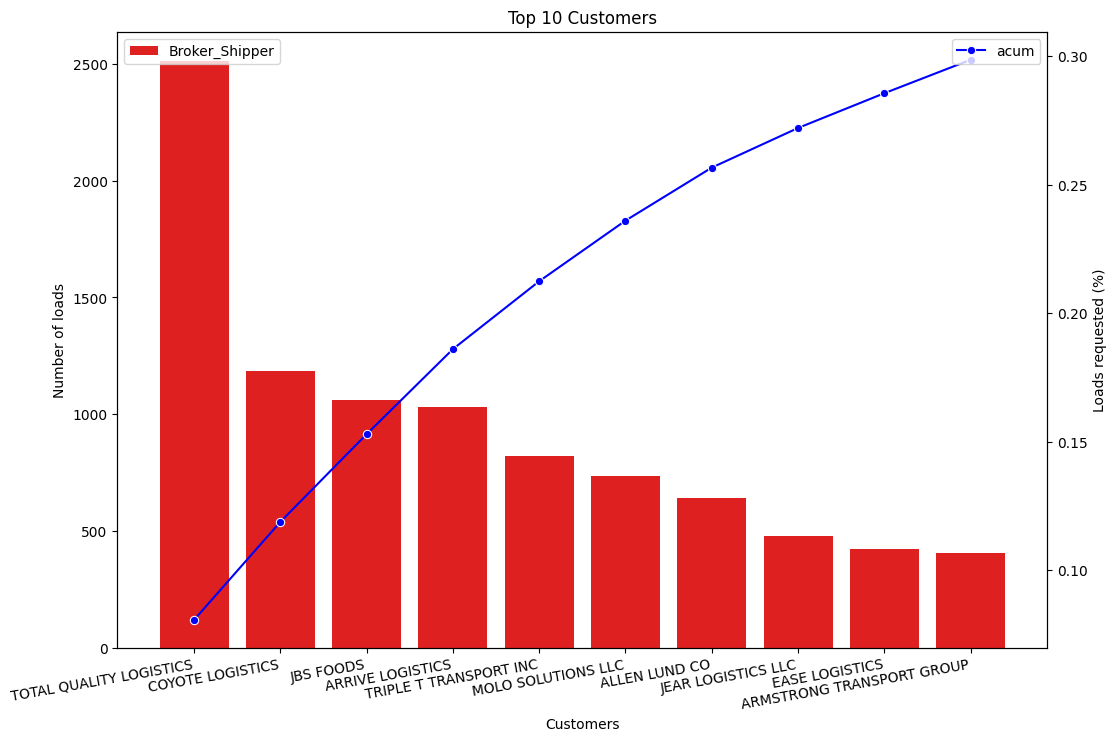

In [7]:
fig, ax1 = plt.subplots(figsize=(12, 8))
sns.barplot(data=piv1.head(10), x='Broker_Shipper', y='ID', color='red', label='Broker_Shipper', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=piv1.head(10), x='Broker_Shipper', y='acum', color='blue', marker='o', 
             ax=ax2, label='acum')
ax1.set_xlabel('Customers')
ax1.set_ylabel('Number of loads')
ax1.legend(loc='upper left')
ax2.set_ylabel('Loads requested (%)')
ax2.legend(loc='upper right')
plt.title('Top 10 Customers')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=10, ha='right', fontsize=10)
plt.show()

Podemos analizar a partir de un diagrama de Pareto, que el 30% de las cargas son transportadas para Brokers como TQL, Coyote Logistics, Triple T Transport, entre otros, que corresponden justo a empresas con alto movimiento de cargas a nivel nacional. Mantener buenas relaciones con estas empresas es crítico porque solicitan servicio de transporte en un alto nivel y en cada una de las regiones del país.

### 1.3 Análisis de 'Dispatchers'

Ahora revisemos cuáles son los despachadores de la empresa, cuánto tiempo llevan perteneciendo a ella y cuántas cargas han transportado durante todo el período de análisis. Este análisis es importante para clasificar los despachadores de mayor experiencia y relevancia durante el proceso.

Hay 2,686 cargas que no tienen un despachador registrado.

In [8]:
df.loc[df['DispatcherUser'].isna(),'DispatcherUser']='Unknown'

In [9]:
min_date=[]
max_date=[]
dispatcher=[]
for i in df['DispatcherUser'].unique():
    min_date.append(df.loc[df['DispatcherUser']==i]['Posted'].min())
    max_date.append(df.loc[df['DispatcherUser']==i]['Posted'].max())
    dispatcher.append(i)
dispatchers = pd.DataFrame({'DispatcherUser': dispatcher, 'mindate': min_date, 'maxdate': max_date})
dispatchers.sort_values("maxdate", ascending = False).head(10)

,DispatcherUser,mindate,maxdate
23,ahours,2021-10-05,2024-07-29
42,acrivitchi,2023-01-10,2024-07-29
10,loadmaster,2021-02-05,2024-07-29
1,Unknown,2021-01-19,2024-07-28
22,aboboc,2021-10-05,2024-07-27
59,alapsin,2023-08-01,2024-07-26
51,anofit,2023-03-22,2024-07-26
54,istog,2023-04-20,2024-07-26
79,rbarbaros,2024-02-22,2024-07-26
75,amajullo,2024-01-02,2024-07-26


Despachadores como 'aboboc', 'acrivitchi', 'ahours', se encuentran desde 2021 hasta la actualidad trabajando en la empresa.

In [10]:
piv1=df.pivot_table(index='DispatcherUser', values='ID', aggfunc='count', fill_value=0).reset_index()
piv1 = piv1.drop(index=0) #2686 cargas no se conoce el despachador
piv1['Total']=piv1['ID'].sum()
piv1['Loads dispatched (%)']=piv1['ID']/piv1['Total']
piv1 = piv1.sort_values(by='Loads dispatched (%)', ascending=False)
piv1['acum']=piv1['Loads dispatched (%)'].cumsum()
piv1=piv1.merge(dispatchers, on='DispatcherUser')

C:\Users\kgome\AppData\Local\Temp\ipykernel_11416\1276098563.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=10, ha='right', fontsize=10)


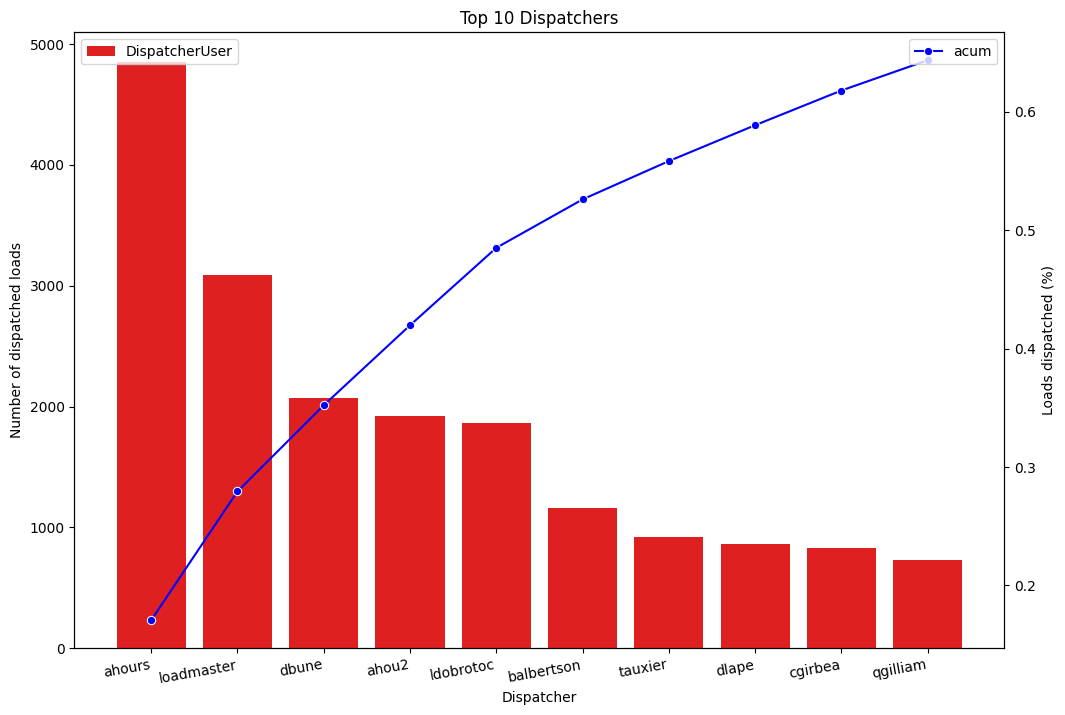

In [11]:
fig, ax1 = plt.subplots(figsize=(12, 8))
sns.barplot(data=piv1.head(10), x='DispatcherUser', y='ID', color='red', label='DispatcherUser', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=piv1.head(10), x='DispatcherUser', y='acum', color='blue', marker='o', 
             ax=ax2, label='acum')
ax1.set_xlabel('Dispatcher')
ax1.set_ylabel('Number of dispatched loads')
ax1.legend(loc='upper left')
ax2.set_ylabel('Loads dispatched (%)')
ax2.legend(loc='upper right')
plt.title('Top 10 Dispatchers')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=10, ha='right', fontsize=10)
plt.show()

A pesar de que en el análisis anterior observabamos que 'aboboc' y 'acrivitchi' llevan ya 3 años aproximadamente en la empresa parecen no haber hecho parte del movimiento de las cargas. Pueden ser contactos administradores. 'ahours' por su parte, está vinculado a más de 4000 cargas. Debe ser el despachador de mayor experiencia de la compañía.

### 1.4 Análisis de Cargas por Estado

Podemos observar en qué estados del país esta empresa tiene mayor operación, y por ende los estados sobre los cuales debe prestar especial atención. Estados con poca cobertura de su operación pueden significar oportunidades perdidas, y estados con alta cobertura significan fortalecer relaciones para mantener el servicio en esos espacios.

In [12]:
piv1=df.pivot_table(index='StateOrigin', values='ID', aggfunc='count', fill_value=0).reset_index()
piv1['Total']=piv1['ID'].sum()
piv1['Loads dispatched (%)']=piv1['ID']/piv1['Total']
piv1 = piv1.sort_values(by='Loads dispatched (%)', ascending=False)

In [13]:
usa_map = gpd.read_file('us_states.geojson')
usa_map = usa_map.rename(columns={'abbr': 'StateOrigin'})
usa_map = usa_map.drop([27])

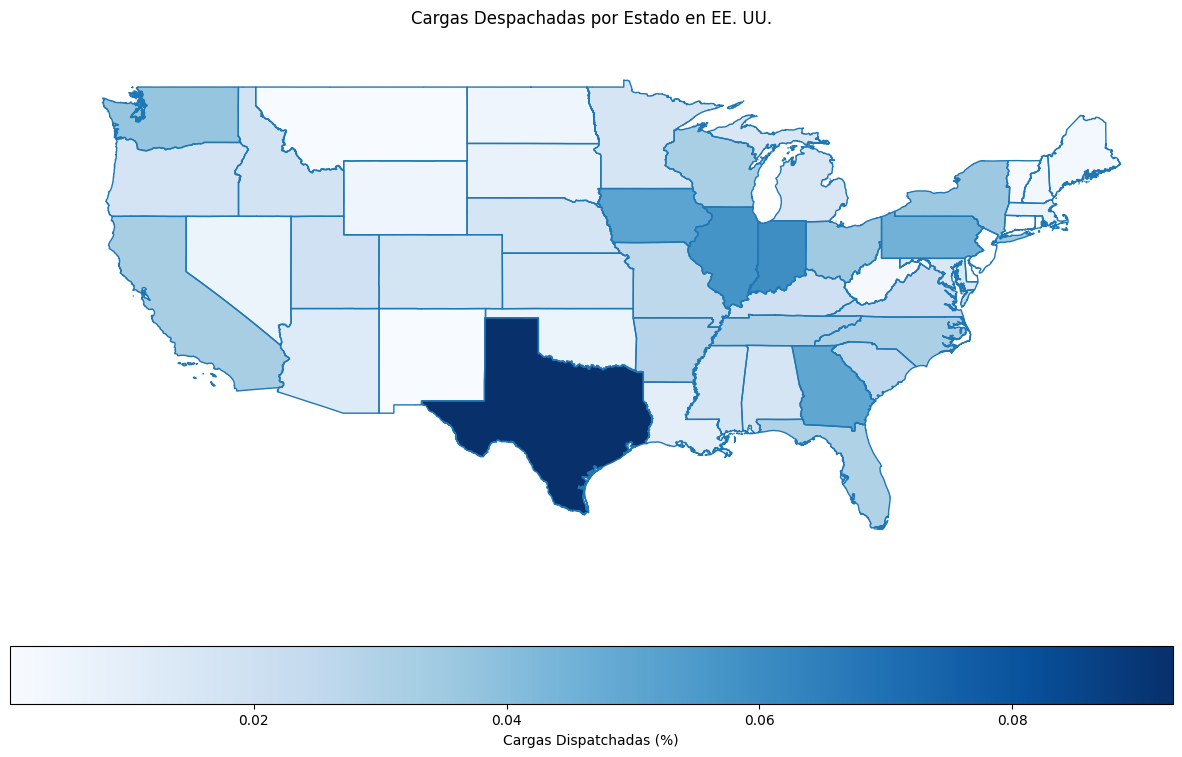

In [14]:
merged = usa_map.set_index('StateOrigin').join(piv1.set_index('StateOrigin'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged.boundary.plot(ax=ax, linewidth=1)
merged.plot(column='Loads dispatched (%)', ax=ax, legend=True,
            legend_kwds={'label': "Cargas Dispatchadas (%)",
                         'orientation': "horizontal"},
            cmap='Blues')  # Puedes elegir el cmap que prefieras

ax.set_xlim([-130, -64])  # Ajusta los límites de x (longitud)
ax.set_ylim([25, 52])      # Ajusta los límites de y (latitud)

ax.set_title('Cargas Despachadas por Estado en EE. UU.')
ax.set_axis_off()
plt.show()

Como podemos observar gran cantidad de cargas se consolidan en la zona este de Estados Unidos y sobre todo Texas, un estado que se conoce bastante en la industria por mover cargar 'inbound' y 'outbound'.

### 1.5 Análisis Retorno vs Esfuerzo

En este apartado calcularemos la serie de tiempo que estaremos analizando durante el proyecto. Es reconocido en la industria que durante la época de pandemia, los rates pagados por los brokers eran bastante altos, a medida que fue pasando el tiempo, los rates disminuyeron y de hecho se habla de una época de recesión donde existe un malestar general de parte de los carriers que afirman que deben trabajar más para obtener el mismo dinero o menos de lo que recibían anteriormente.

Analicemos entonces el número de cargas que tiene registradas esta empresa en el tiempo, así como distancias recorridas en total por sus camiones durante el transporte de estas, versus el nivel de ingreso que recibieron.

In [15]:
df['Posted'] = pd.to_datetime(df['Posted'])
df = df.sort_values('Posted')
df.index = df['Posted']

In [16]:
dfsum = df[['RateTotal', 'Distance','RatePerMile']].resample('D').sum()
dfcount = df['Posted'].resample('D').count()
df=dfsum.join(dfcount.rename('Loads'))

In [17]:
df=df.drop(df.index[-1])
df['RatePerMile'] = df['RateTotal']/df['Distance']

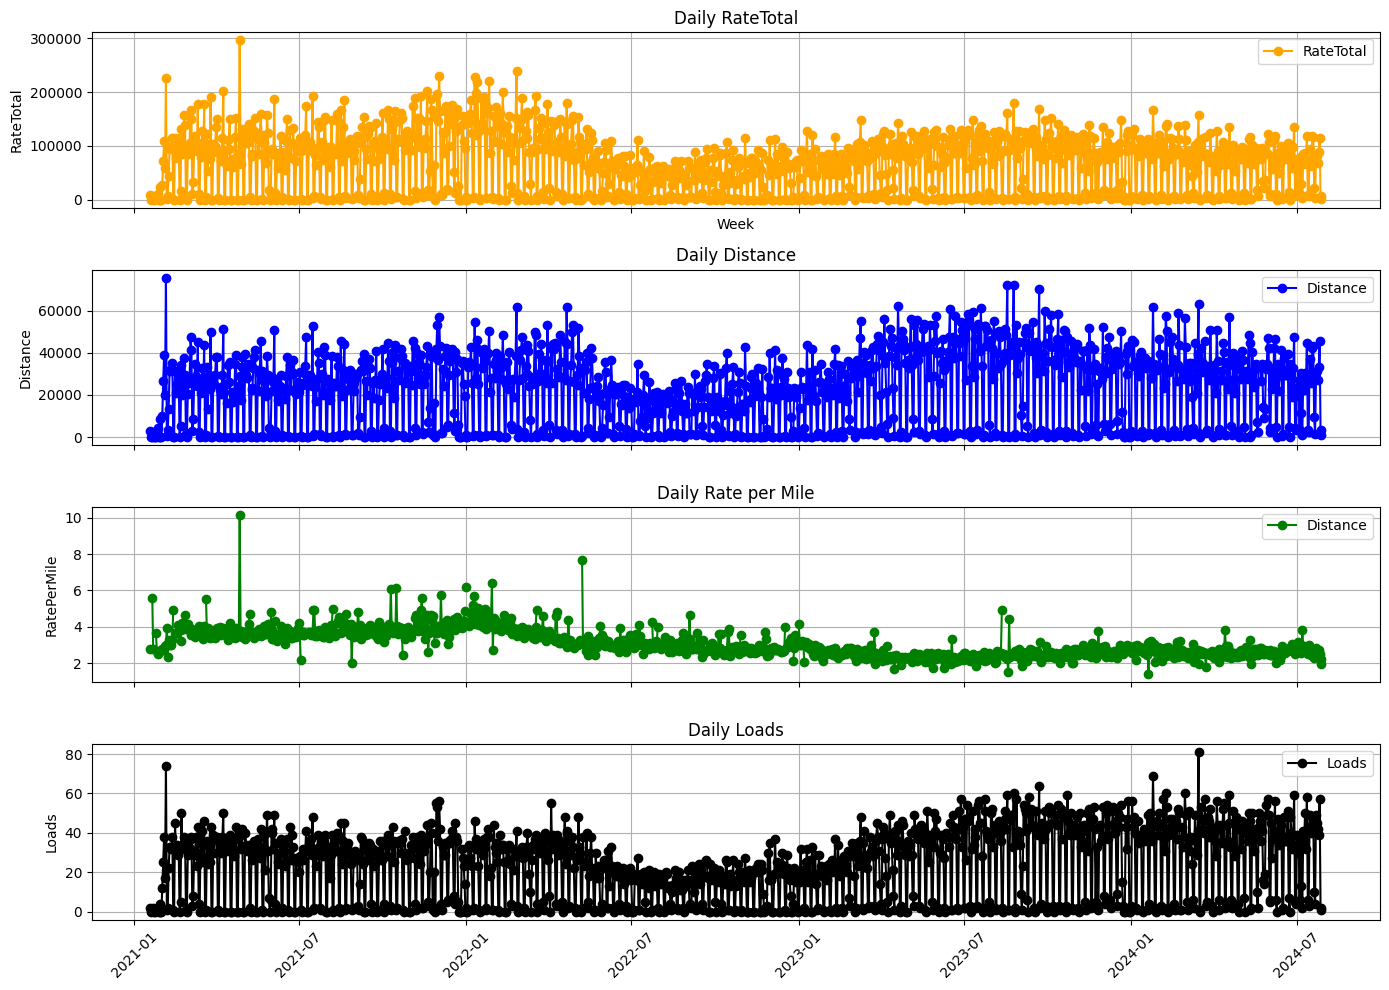

In [18]:
fig, (ax2, ax1, ax3, ax4) = plt.subplots(nrows=4, ncols=1, figsize=(14, 10), sharex=True)

ax2.plot(df.index, df['RateTotal'], color='orange', label='RateTotal', marker='o')
ax2.set_title('Daily RateTotal')
ax2.set_xlabel('Week')
ax2.set_ylabel('RateTotal')
ax2.legend()
ax2.grid()

ax1.plot(df.index, df['Distance'], color='blue', label='Distance', marker='o')
ax1.set_title('Daily Distance')
ax1.set_ylabel('Distance')
ax1.legend()
ax1.grid()

ax3.plot(df.index, df['RatePerMile'], color='green', label='Distance', marker='o')
ax3.set_title('Daily Rate per Mile')
ax3.set_ylabel('RatePerMile')
ax3.legend()
ax3.grid()

ax4.plot(df.index, df['Loads'], color='black', label='Loads', marker='o')
ax4.set_title('Daily Loads')
ax4.set_ylabel('Loads')
ax4.legend()
ax4.grid()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Existe un comportamiento bastante interesante cuando comparamos estas series de tiempo porque se observa como el número de cargas y millas recorridas aumentaron en el último año y medio, sin embargo, el dinero recibido por milla o dinero total se mantiene constante e incluso ha disminuido con respecto a la cantidad de dinero recibida los primeros dos años de la base de datos.

Esto significa que a pesar de que tengan mayor capacidad y gastos operativos que cubrir, esto no significa que estén recibiendo un alto retorno monetario para poder cubrir sus costos.

## 2. Análisis de la Demanda de Cargas Diarias

La serie de tiempo que analizaremos se centra en la demanda diaria de cargas, con el objetivo de pronosticar cuántas cargas se deben supervisar cada día. Esto permitirá al equipo de operaciones de la empresa planificar adecuadamente los recursos necesarios para asegurar un monitoreo eficiente de las entregas y minimizar el desperdicio por parte de los conductores.

Partimos de la premisa de que una gestión adecuada de las entregas no solo mejorará la percepción de la empresa ante sus clientes, sino que también contribuirá a la estabilidad en situaciones de escasez de cargas. Además, su nivel de experiencia en la carretera combinado con un alto nivel de calidad en el servicio permitirán negociar pagos más competitivos.

In [19]:
#Exportar df
df['Posted_date']=df.index
df.to_excel('loadsts.xlsx', index=False)